<a href="https://colab.research.google.com/github/suresh-venkate/Code_Repositories/blob/main/Deep_Learning/Natural_Language_Processing/Transformer_Models/Transformer_From_Scratch/Transformer_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer from scratch

* Reference: Attention is all you need, NIPS 2017
* Authors: Ashish Vaswani et.al.
* Link to paper: [Link](https://arxiv.org/abs/1706.03762)
* All references in the code below refer to this paper unless stated otherwise

# Import required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math, copy, time
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchsummary import summary as ts_summary
from torch.autograd import Variable

# Define Functions

## Function: clones

In [2]:
def clones(module, N):
    """
    Produce N identical layers of module
    Arguments:
      module: module to be cloned
      N: Number of time the module will be cloned
    Returns:
      Cloned module
    """
    cloned_module = nn.ModuleList([copy.deepcopy(module) for _ in range(N)])
    return cloned_module

## Verify Function: clones

In [3]:
class TempModel(nn.Module):
  def __init__(self, layer, N):
    super(TempModel, self).__init__()
    self.layers = clones(layer, N)

  def forward(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

device = "cuda" if torch.cuda.is_available() else "cpu"
lin_layer = nn.Linear(128, 128)
temp_model = TempModel(lin_layer, 4).to(device) # Clone linear layer 4 times
ts_summary(temp_model, input_size = (128,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]          16,512
            Linear-2                  [-1, 128]          16,512
            Linear-3                  [-1, 128]          16,512
            Linear-4                  [-1, 128]          16,512
Total params: 66,048
Trainable params: 66,048
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.25
Estimated Total Size (MB): 0.26
----------------------------------------------------------------


# Define Classes

## Class: ScaledDotProductAttention

In [4]:
class ScaledDotProductAttention(nn.Module):
  """
  Compute Scaled Dot Product Attention (Ref: Section 3.2.1, Figure 2 (left))
  """

  def __init__(self, scaling):
    """
    Arguments:
      scaling: scaling to use while computing attention
    """
    super(ScaledDotProductAttention, self).__init__()
    self.scaling = scaling
    self.softmax = nn.Softmax(dim = -1)
  
  def forward(self, Q, K, V, attn_mask = None):
    """
    Arguments:
      Q: Query tensor
      K: Key tensor
      V: Value tensor
      attn_mask: Optional mask to mask out some query-key combinations
    Returns:
      probs: softmax(Q * K.T / scaling)
      attn: probs.V
    """
    scores = torch.matmul(Q, K.transpose(-2, -1)) # Matmul of Q and K
    scores = scores / self.scaling # Apply Scaling to maintain original variance
    if attn_mask is not None: # Apply mask (optional)
      scores = scores.masked_fill(attn_mask == 0, -1e9)
    probs = self.softmax(scores) # Compute softmax
    attn = torch.matmul(probs, V)

    return attn, probs

### Verify Class: ScaledDotProductAttention

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
temp_model = ScaledDotProductAttention(4).to(device) # Clone linear layer 4 times

Q = torch.randint(0, 10, (2, 3, 5, 16), dtype = torch.float32)
K = torch.clone(Q)
V = torch.clone(Q)

attn, probs = temp_model(Q, K, V)
attn = torch.ceil(attn)

print(Q.shape, attn.shape, probs.shape)
print()
print(Q[0, 0])
print()
print(probs[0, 0])
print()
print(attn[0, 0])

torch.Size([2, 3, 5, 16]) torch.Size([2, 3, 5, 16]) torch.Size([2, 3, 5, 5])

tensor([[2., 6., 4., 6., 7., 8., 0., 0., 2., 1., 4., 2., 8., 7., 9., 5.],
        [4., 3., 0., 9., 7., 1., 2., 8., 9., 3., 4., 4., 8., 6., 0., 1.],
        [0., 4., 3., 2., 6., 0., 0., 6., 8., 1., 6., 9., 4., 2., 4., 4.],
        [9., 6., 8., 2., 1., 0., 0., 3., 4., 7., 4., 3., 6., 2., 6., 8.],
        [0., 2., 1., 7., 2., 2., 5., 2., 4., 1., 4., 8., 0., 5., 5., 4.]])

tensor([[1.0000e+00, 1.1548e-17, 3.1800e-22, 4.0307e-17, 1.2996e-24],
        [1.9040e-17, 1.0000e+00, 2.3195e-16, 1.8299e-21, 4.5360e-24],
        [7.5800e-10, 3.3535e-04, 9.9966e-01, 5.9033e-10, 8.8753e-13],
        [1.6261e-14, 4.4777e-19, 9.9912e-20, 1.0000e+00, 1.1851e-27],
        [1.9179e-03, 4.0601e-03, 5.4947e-04, 4.3350e-09, 9.9347e-01]])

tensor([[2., 6., 4., 6., 7., 8., 1., 1., 2., 1., 4., 2., 8., 7., 9., 5.],
        [4., 3., 1., 9., 7., 1., 2., 8., 9., 3., 4., 4., 8., 6., 1., 1.],
        [1., 4., 3., 3., 7., 1., 1., 7., 9., 2., 6

## Class: MultiHeadAttention

In [6]:
class MultiHeadAttention(nn.Module):
  """
  Compute Multi-Head Attention (Ref: Section 3.2.2, Figure 2 (right))
  """
  def __init__(self, h, d_model, attn_dropout = 0.1):
    """
    Arguments:
      h: Number of parallel attention layers (heads)
      d_model: Size of input embeddings
      attn_dropout: dropout value to use in MHA module
    """
    super(MultiHeadAttention, self).__init__()
    assert d_model % h == 0 # Confirm that input embedding size is a multiple of # heads
    self.d_k = d_model // h # Dimension of projected outputs
    self.h = h # Number of heads
    self.attn = None # Placeholder to store attention softmax output

    # Define linear layers for projecting Q, K, V
    self.wi_q = nn.Linear(d_model, d_model, bias = False)
    self.wi_k = nn.Linear(d_model, d_model, bias = False)
    self.wi_v = nn.Linear(d_model, d_model, bias = False)

    # Define SDPA layer
    self.attention = ScaledDotProductAttention(scaling = self.d_k ** 0.5)

    # Define final FC and dropout layers
    self.fc = nn.Linear(d_model, d_model, bias = False)
    self.dropout = nn.Dropout(p = attn_dropout)
        
  def forward(self, Q, K, V, mask = None):
    if mask is not None:
      mask = mask.unsqueeze(1) # Head axis broadcasting - Same mask applied to all h heads.
    
    nb = Q.size(0) # Extract number of batches in Q 
    # Q, K, V are of shape nb x lq x d_model
    # Pass through linear layers and separate each head to get
    # outputs of shape nb x lq x h x d_k
    Q = self.wi_q(Q).view(nb, -1, self.h, self.d_k)
    K = self.wi_k(K).view(nb, -1, self.h, self.d_k)
    V = self.wi_v(V).view(nb, -1, self.h, self.d_k)

    # Transpose lq and h for attention dot product
    # Shape is now nb x h x lq x d_k
    Q, K, V = Q.transpose(1, 2), K.transpose(1, 2), V.transpose(1, 2)
        
    # Apply Scaled Dot Product Attention
    # Shape of x is nb x h x lq x d_k
    x, self.attn = self.attention(Q, K, V, attn_mask = mask)

    # Transpose nb and h dimensions and concatenate all heads together into 
    # a single unit of dimension h x d_k = d_model 
    x = x.transpose(1, 2).contiguous().view(nb, -1, self.h * self.d_k)

    # Apply final linear layer and dropout
    x = self.dropout(self.fc(x))
    
    return x

### Verify Class: MultiHeadAttention


In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
temp_model = MultiHeadAttention(h = 8, d_model = 512, attn_dropout = 0.0).to(device)

Q = torch.randint(0, 10, (2, 5, 512), dtype = torch.float32).to(device)
K = torch.clone(Q)
V = torch.clone(Q)

x = temp_model(Q, K, V, mask = None)
print(x.shape, temp_model.attn.shape)

torch.Size([2, 5, 512]) torch.Size([2, 8, 5, 5])


## Class: Embeddings

In [8]:
class Embeddings(nn.Module):
  """
  Defines embedding layer to use at inputs of encoder and decoder. (Ref: Section 3.4)
  """
  def __init__(self, d_model, vocab):
    """
    Arguments:
      d_model: Size of the embedding vector
      vocab: Size of input vocabulary
    """
    super(Embeddings, self).__init__()
    self.emb = nn.Embedding(vocab, d_model) 
    self.d_model = d_model

  def forward(self, x):
    return self.emb(x) * math.sqrt(self.d_model)

### Verify Class: Embeddings

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
src_vocab = 11 # 0 to 10
d_model = 512
temp_model = Embeddings(d_model, src_vocab).to(device)

# Generate 5 input samples of length 10 each
input = torch.randint(0, 10, (5, 10)).to(device)
output = temp_model(input)

print(input.shape, output.shape)

torch.Size([5, 10]) torch.Size([5, 10, 512])


## Class: PositionalEncoding

In [10]:
class PositionalEncoding(nn.Module):
    """
    Implement the PositionalEncoding Function. (Ref: Section 3.5)
    """
    def __init__(self, d_model, dropout, max_posns = 5000):
      """
      Arguments: d_model = Size of the embedding vector
      dropout: Dropout value to use at the output of this layer
      """
      super(PositionalEncoding, self).__init__()
      #self.norm = nn.LayerNorm(d_model, eps = 1e-6)
      self.dropout = nn.Dropout(p = dropout)
      pe = torch.zeros(max_posns, d_model) # Placeholder to store pos. encodings
      posn_vec = torch.arange(0, max_posns).unsqueeze(1) # Position vector
      expn = torch.arange(0, d_model, 2) / d_model # Exponent term for the denominator
      pe[:, 0::2] = torch.sin(posn_vec / (10000 ** expn))
      pe[:, 1::2] = torch.cos(posn_vec / (10000 ** expn))
      pe = pe.unsqueeze(0) # Add batch axis
      self.register_buffer('pe', pe) # Register 'pe' as a non-model parameter
        
    def forward(self, x):
      x = x + self.pe[:, :x.size(1)].clone().detach()
      return self.dropout(x)

### Verify Class: PositionalEncoding

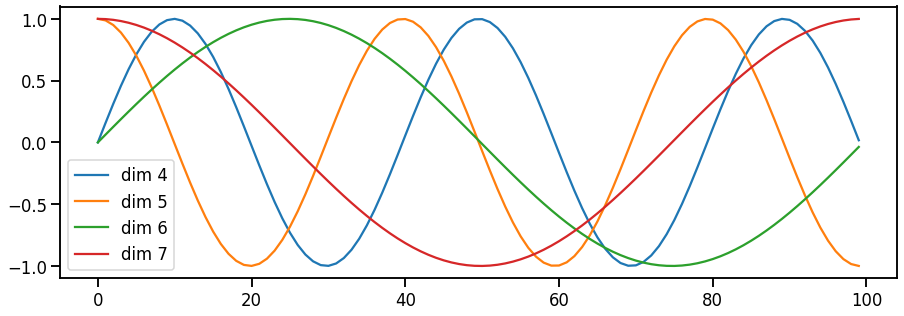

In [11]:
d_model = 20
pe = PositionalEncoding(d_model, dropout = 0)
input = torch.zeros(1, 100, 20)
output = pe.forward(input)

plt.figure(figsize=(15, 5))
plt.plot(np.arange(100), output[0, :, 4:8].numpy())
plt.legend(["dim %d" %p for p in [4, 5, 6, 7]])
plt.show()

## Class: AddAndNorm

In [12]:
class AddAndNorm(nn.Module):
  """
  Add a residual connection followed by a layer norm. (Ref: Section 5.4, Residual Dropout)
  """
  def __init__(self, size):
    super(AddAndNorm, self).__init__()
    self.norm = nn.LayerNorm(size, eps = 1e-6)
    
  def forward(self, x, sublayer):
    return self.norm(x + sublayer(x))

In [13]:
class AddAndNormDec(nn.Module):
  """
  Add a residual connection followed by a layer norm.
  """
  def __init__(self, size):
    super(AddAndNormDec, self).__init__()
    self.norm = nn.LayerNorm(size, eps = 1e-6)
    
  def forward(self, x, sublayer):
    #return self.norm(x + sublayer(x))
    return x + sublayer(self.norm(x))

In [14]:
# #### TEMP
# class tempenclayer(nn.Module):
#     def __init__(self, size, self_attn):
#       super(tempenclayer, self).__init__()
#       self.self_attn = self_attn
#       self.add_and_norm = AddAndNorm(size)

#     def forward(self, x):
#       x = self.add_and_norm(x, lambda x: self.self_attn(x, x, x, None)
#       return x

In [15]:
# device = "cuda" if torch.cuda.is_available() else "cpu"
# attn = MultiHeadAttention(8, 512).to(device)
# addandnorm = AddAndNorm(512).to(device)

# # # Generate 5 input samples of length 10 each
# # input = torch.randint(0, 10, (5, 10)).to(device)
# # output = temp_model(input)

# # print(input.shape, output.shape)
# #ts_summary(temp_model, input_size = (10, 512))
# Q = torch.randint(0, 10, (2, 5, 512), dtype = torch.float32).to(device)
# K = torch.clone(Q)
# V = torch.clone(Q)

# x = attn(Q, K, V, mask = None)
# y = addandnorm

## Class: PositionWiseFeedForward

In [16]:
class PositionwiseFeedForward(nn.Module):
  """
  Implements the position-wise feed-forward layer (Ref: Section 3.3, Eqn. (2))
  """
  def __init__(self, d_model, d_ff, dropout = 0.1):
    """
    Arguments: 
      d_model: Dimensionality of input and output of PWFFN layer
      d_ff: Dimension of hidden layer
      dropout: Dropout value to use
    """
    super(PositionwiseFeedForward, self).__init__()
    self.fc_1 = nn.Linear(d_model, d_ff) # First transformation
    self.fc_2 = nn.Linear(d_ff, d_model) # Second transformation
    self.relu = nn.ReLU()  
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    x = self.relu(self.fc_1(x))
    x = self.dropout(self.fc_2(x))
    return x

# Backup_1

## Define classes and Functions

In [17]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [18]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

In [19]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = nn.LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        x = self.norm(x)
        for layer in self.layers:
            x = layer(x, mask)
        #return self.norm(x)
        return x

In [20]:
# class SublayerConnection(nn.Module):
#     """
#     A residual connection followed by a layer norm.
#     Note for code simplicity the norm is first as opposed to last.
#     """
#     def __init__(self, size, dropout):
#         super(SublayerConnection, self).__init__()
#         self.norm = LayerNorm(size)
#         self.dropout = nn.Dropout(dropout)

#     def forward(self, x, sublayer):
#         "Apply residual connection to any sublayer with the same size."
#         return x + self.dropout(sublayer(self.norm(x)))

In [21]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(AddAndNorm(size), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

In [22]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = nn.LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
      x = self.norm(x)
      for layer in self.layers:
          x = layer(x, memory, src_mask, tgt_mask)
      return self.norm(x)

In [23]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(AddAndNormDec(size), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

In [24]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

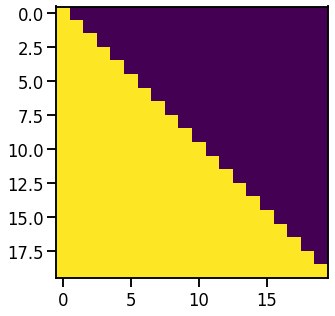

In [25]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])
None

In [26]:
# class PositionwiseFeedForward(nn.Module):
#     "Implements FFN equation."
#     def __init__(self, d_model, d_ff, dropout=0.1):
#         super(PositionwiseFeedForward, self).__init__()
#         self.w_1 = nn.Linear(d_model, d_ff)
#         self.w_2 = nn.Linear(d_ff, d_model)
#         self.dropout = nn.Dropout(dropout)

#     def forward(self, x):
#         return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [27]:
def make_model(src_vocab, tgt_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

In [28]:
# Small example model.
tmp_model = make_model(10, 10, 2)
tmp_model

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadAttention(
          (wi_q): Linear(in_features=512, out_features=512, bias=False)
          (wi_k): Linear(in_features=512, out_features=512, bias=False)
          (wi_v): Linear(in_features=512, out_features=512, bias=False)
          (attention): ScaledDotProductAttention(
            (softmax): Softmax(dim=-1)
          )
          (fc): Linear(in_features=512, out_features=512, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (fc_1): Linear(in_features=512, out_features=2048, bias=True)
          (fc_2): Linear(in_features=2048, out_features=512, bias=True)
          (relu): ReLU()
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0): AddAndNorm(
            (norm): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
          

In [29]:
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask

In [30]:
def run_epoch(data_iter, model, loss_compute):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(batch.src, batch.trg, 
                            batch.src_mask, batch.trg_mask)
        loss = loss_compute(out, batch.trg_y, batch.ntokens)
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 50 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f" %
                    (i, loss / batch.ntokens, tokens / elapsed))
            start = time.time()
            tokens = 0
    return total_loss / total_tokens

In [31]:
global max_src_in_batch, max_tgt_in_batch
def batch_size_fn(new, count, sofar):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max(max_src_in_batch,  len(new.src))
    max_tgt_in_batch = max(max_tgt_in_batch,  len(new.trg) + 2)
    src_elements = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch
    return max(src_elements, tgt_elements)

In [32]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

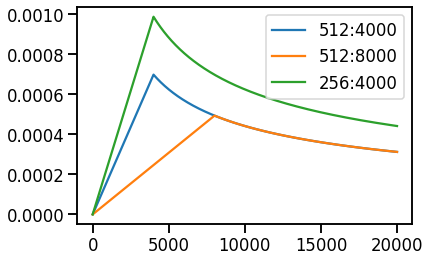

In [33]:
# Three settings of the lrate hyperparameters.
opts = [NoamOpt(512, 1, 4000, None), 
        NoamOpt(512, 1, 8000, None),
        NoamOpt(256, 1, 4000, None)]
plt.plot(np.arange(1, 20000), [[opt.rate(i) for opt in opts] for i in range(1, 20000)])
plt.legend(["512:4000", "512:8000", "256:4000"])
None

In [34]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


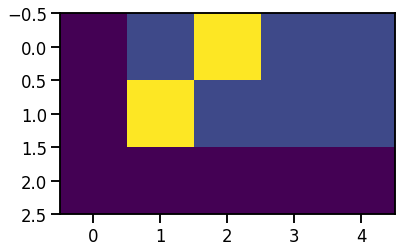

In [35]:
#Example of label smoothing.
crit = LabelSmoothing(5, 0, 0.4)
predict = torch.FloatTensor([[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]])
v = crit(Variable(predict.log()), 
         Variable(torch.LongTensor([2, 1, 0])))

# Show the target distributions expected by the system.
plt.imshow(crit.true_dist)
None

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


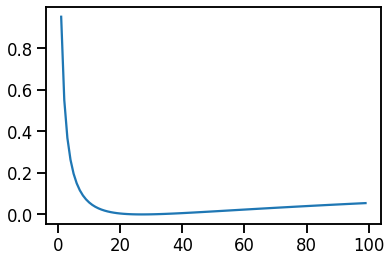

In [36]:
crit = LabelSmoothing(5, 0, 0.1)
def loss(x):
    d = x + 3 * 1
    predict = torch.FloatTensor([[0, x / d, 1 / d, 1 / d, 1 / d],
                                 ])
    #print(predict)
    return crit(Variable(predict.log()),
                 Variable(torch.LongTensor([1]))).item()
plt.plot(np.arange(1, 100), [loss(x) for x in range(1, 100)])
None

## Synthetic Data

In [37]:
def data_gen(V, batch, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data = torch.from_numpy(np.random.randint(1, V, size=(batch, 10)))
        data[:, 0] = 1
        src = Variable(data, requires_grad=False)
        tgt = Variable(data, requires_grad=False)
        yield Batch(src, tgt, 0)

## Loss Computation

In [38]:
class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        #return loss.data[0] * norm
        return loss.item() * norm

## Greedy Decoding

In [42]:
# Train the simple copy task.
V = 11
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)
model = make_model(V, V, N=2)
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

for epoch in range(10):
    model.train()
    run_epoch(data_gen(V, 30, 20), model, 
              SimpleLossCompute(model.generator, criterion, model_opt))
    model.eval()
    print(run_epoch(data_gen(V, 30, 5), model, 
                    SimpleLossCompute(model.generator, criterion, None)))

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Epoch Step: 1 Loss: 3.132079 Tokens per Sec: 467.278503
Epoch Step: 1 Loss: 1.805031 Tokens per Sec: 613.339172
tensor(1.7992)
Epoch Step: 1 Loss: 1.925091 Tokens per Sec: 493.439453
Epoch Step: 1 Loss: 1.699711 Tokens per Sec: 619.733032
tensor(1.7158)
Epoch Step: 1 Loss: 1.863919 Tokens per Sec: 497.787933
Epoch Step: 1 Loss: 1.600698 Tokens per Sec: 607.599792
tensor(1.6193)
Epoch Step: 1 Loss: 1.855049 Tokens per Sec: 478.457214
Epoch Step: 1 Loss: 1.401303 Tokens per Sec: 612.620972
tensor(1.4189)
Epoch Step: 1 Loss: 1.737799 Tokens per Sec: 494.972015
Epoch Step: 1 Loss: 1.611237 Tokens per Sec: 611.880066
tensor(1.5767)
Epoch Step: 1 Loss: 1.686326 Tokens per Sec: 482.089020
Epoch Step: 1 Loss: 1.163877 Tokens per Sec: 621.485291
tensor(1.1478)
Epoch Step: 1 Loss: 1.607196 Tokens per Sec: 499.686646
Epoch Step: 1 Loss: 1.009444 Tokens per Sec: 623.543762
tensor(0.9829)
Epoch Step: 1 Loss: 1.213488 Tokens per Sec: 491.215027
Epoch Step: 1 Loss: 0.659119 Tokens per Sec: 596.252991

In [40]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

In [43]:
model.eval()
src = Variable(torch.LongTensor([[1,8,5,7,3,6,7,8,9,10]]))
#src = Variable(torch.LongTensor([[1,8,5,7,3,6,7,8,9,10]]))
src_mask = Variable(torch.ones(1, 1, 10))
print(greedy_decode(model, src, src_mask, max_len=10, start_symbol=1))

tensor([[ 1,  8,  5,  7,  3,  6,  8,  7,  8, 10]])


# Backup_2

# A Real World Example

> Now we consider a real-world example using the IWSLT German-English Translation task. This task is much smaller than the WMT task considered in the paper, but it illustrates the whole system. We also show how to use multi-gpu processing to make it really fast.

In [ ]:
#!pip install torchtext spacy
#!python -m spacy download en
#!python -m spacy download de

## Data Loading
> We will load the dataset using torchtext and spacy for tokenization. 

In [ ]:
# For data loading.
from torchtext import data, datasets

if True:
    import spacy
    spacy_de = spacy.load('de')
    spacy_en = spacy.load('en')

    def tokenize_de(text):
        return [tok.text for tok in spacy_de.tokenizer(text)]

    def tokenize_en(text):
        return [tok.text for tok in spacy_en.tokenizer(text)]

    BOS_WORD = '<s>'
    EOS_WORD = '</s>'
    BLANK_WORD = "<blank>"
    SRC = data.Field(tokenize=tokenize_de, pad_token=BLANK_WORD)
    TGT = data.Field(tokenize=tokenize_en, init_token = BOS_WORD, 
                     eos_token = EOS_WORD, pad_token=BLANK_WORD)

    MAX_LEN = 100
    train, val, test = datasets.IWSLT.splits(
        exts=('.de', '.en'), fields=(SRC, TGT), 
        filter_pred=lambda x: len(vars(x)['src']) <= MAX_LEN and 
            len(vars(x)['trg']) <= MAX_LEN)
    MIN_FREQ = 2
    SRC.build_vocab(train.src, min_freq=MIN_FREQ)
    TGT.build_vocab(train.trg, min_freq=MIN_FREQ)

> Batching matters a ton for speed. We want to have very evenly divided batches, with absolutely minimal padding. To do this we have to hack a bit around the default torchtext batching. This code patches their default batching to make sure we search over enough sentences to find tight batches. 

## Iterators

In [ ]:
class MyIterator(data.Iterator):
    def create_batches(self):
        if self.train:
            def pool(d, random_shuffler):
                for p in data.batch(d, self.batch_size * 100):
                    p_batch = data.batch(
                        sorted(p, key=self.sort_key),
                        self.batch_size, self.batch_size_fn)
                    for b in random_shuffler(list(p_batch)):
                        yield b
            self.batches = pool(self.data(), self.random_shuffler)
            
        else:
            self.batches = []
            for b in data.batch(self.data(), self.batch_size,
                                          self.batch_size_fn):
                self.batches.append(sorted(b, key=self.sort_key))

def rebatch(pad_idx, batch):
    "Fix order in torchtext to match ours"
    src, trg = batch.src.transpose(0, 1), batch.trg.transpose(0, 1)
    return Batch(src, trg, pad_idx)

## Multi-GPU Training

> Finally to really target fast training, we will use multi-gpu. This code implements multi-gpu word generation. It is not specific to transformer so I won't go into too much detail. The idea is to split up word generation at training time into chunks to be processed in parallel across many different gpus. We do this using pytorch parallel primitives:

* replicate - split modules onto different gpus.
* scatter - split batches onto different gpus
* parallel_apply - apply module to batches on different gpus
* gather - pull scattered data back onto one gpu. 
* nn.DataParallel - a special module wrapper that calls these all before evaluating. 


In [ ]:
# Skip if not interested in multigpu.
class MultiGPULossCompute:
    "A multi-gpu loss compute and train function."
    def __init__(self, generator, criterion, devices, opt=None, chunk_size=5):
        # Send out to different gpus.
        self.generator = generator
        self.criterion = nn.parallel.replicate(criterion, 
                                               devices=devices)
        self.opt = opt
        self.devices = devices
        self.chunk_size = chunk_size
        
    def __call__(self, out, targets, normalize):
        total = 0.0
        generator = nn.parallel.replicate(self.generator, 
                                                devices=self.devices)
        out_scatter = nn.parallel.scatter(out, 
                                          target_gpus=self.devices)
        out_grad = [[] for _ in out_scatter]
        targets = nn.parallel.scatter(targets, 
                                      target_gpus=self.devices)

        # Divide generating into chunks.
        chunk_size = self.chunk_size
        for i in range(0, out_scatter[0].size(1), chunk_size):
            # Predict distributions
            out_column = [[Variable(o[:, i:i+chunk_size].data, 
                                    requires_grad=self.opt is not None)] 
                           for o in out_scatter]
            gen = nn.parallel.parallel_apply(generator, out_column)

            # Compute loss. 
            y = [(g.contiguous().view(-1, g.size(-1)), 
                  t[:, i:i+chunk_size].contiguous().view(-1)) 
                 for g, t in zip(gen, targets)]
            loss = nn.parallel.parallel_apply(self.criterion, y)

            # Sum and normalize loss
            l = nn.parallel.gather(loss, 
                                   target_device=self.devices[0])
            l = l.sum()[0] / normalize
            total += l.data[0]

            # Backprop loss to output of transformer
            if self.opt is not None:
                l.backward()
                for j, l in enumerate(loss):
                    out_grad[j].append(out_column[j][0].grad.data.clone())

        # Backprop all loss through transformer.            
        if self.opt is not None:
            out_grad = [Variable(torch.cat(og, dim=1)) for og in out_grad]
            o1 = out
            o2 = nn.parallel.gather(out_grad, 
                                    target_device=self.devices[0])
            o1.backward(gradient=o2)
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return total * normalize

> Now we create our model, criterion, optimizer, data iterators, and paralelization

In [ ]:
# GPUs to use
devices = [0, 1, 2, 3]
if True:
    pad_idx = TGT.vocab.stoi["<blank>"]
    model = make_model(len(SRC.vocab), len(TGT.vocab), N=6)
    model.cuda()
    criterion = LabelSmoothing(size=len(TGT.vocab), padding_idx=pad_idx, smoothing=0.1)
    criterion.cuda()
    BATCH_SIZE = 12000
    train_iter = MyIterator(train, batch_size=BATCH_SIZE, device=0,
                            repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                            batch_size_fn=batch_size_fn, train=True)
    valid_iter = MyIterator(val, batch_size=BATCH_SIZE, device=0,
                            repeat=False, sort_key=lambda x: (len(x.src), len(x.trg)),
                            batch_size_fn=batch_size_fn, train=False)
    model_par = nn.DataParallel(model, device_ids=devices)
None

> Now we train the model. I will play with the warmup steps a bit, but everything else uses the default parameters.  On an AWS p3.8xlarge with 4 Tesla V100s, this runs at ~27,000 tokens per second with a batch size of 12,000 

## Training the System

In [ ]:
#!wget https://s3.amazonaws.com/opennmt-models/iwslt.pt

In [ ]:
if False:
    model_opt = NoamOpt(model.src_embed[0].d_model, 1, 2000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
    for epoch in range(10):
        model_par.train()
        run_epoch((rebatch(pad_idx, b) for b in train_iter), 
                  model_par, 
                  MultiGPULossCompute(model.generator, criterion, 
                                      devices=devices, opt=model_opt))
        model_par.eval()
        loss = run_epoch((rebatch(pad_idx, b) for b in valid_iter), 
                          model_par, 
                          MultiGPULossCompute(model.generator, criterion, 
                          devices=devices, opt=None))
        print(loss)
else:
    model = torch.load("iwslt.pt")

> Once trained we can decode the model to produce a set of translations. Here we simply translate the first sentence in the validation set. This dataset is pretty small so the translations with greedy search are reasonably accurate. 

In [ ]:
for i, batch in enumerate(valid_iter):
    src = batch.src.transpose(0, 1)[:1]
    src_mask = (src != SRC.vocab.stoi["<blank>"]).unsqueeze(-2)
    out = greedy_decode(model, src, src_mask, 
                        max_len=60, start_symbol=TGT.vocab.stoi["<s>"])
    print("Translation:", end="\t")
    for i in range(1, out.size(1)):
        sym = TGT.vocab.itos[out[0, i]]
        if sym == "</s>": break
        print(sym, end =" ")
    print()
    print("Target:", end="\t")
    for i in range(1, batch.trg.size(0)):
        sym = TGT.vocab.itos[batch.trg.data[i, 0]]
        if sym == "</s>": break
        print(sym, end =" ")
    print()
    break

# Additional Components: BPE, Search, Averaging

> So this mostly covers the transformer model itself. There are four aspects that we didn't cover explicitly. We also have all these additional features implemented in [OpenNMT-py](https://github.com/opennmt/opennmt-py).



> 1) BPE/ Word-piece: We can use a library to first preprocess the data into subword units. See Rico Sennrich's [subword-nmt](https://github.com/rsennrich/subword-nmt) implementation. These models will transform the training data to look like this:

▁Die ▁Protokoll datei ▁kann ▁ heimlich ▁per ▁E - Mail ▁oder ▁FTP ▁an ▁einen ▁bestimmte n ▁Empfänger ▁gesendet ▁werden .

> 2) Shared Embeddings: When using BPE with shared vocabulary we can share the same weight vectors between the source / target / generator. See the [(cite)](https://arxiv.org/abs/1608.05859) for details. To add this to the model simply do this:

In [ ]:
if False:
    model.src_embed[0].lut.weight = model.tgt_embeddings[0].lut.weight
    model.generator.lut.weight = model.tgt_embed[0].lut.weight

> 3) Beam Search: This is a bit too complicated to cover here. See the [OpenNMT-py](https://github.com/OpenNMT/OpenNMT-py/blob/master/onmt/translate/Beam.py) for a pytorch implementation.



> 4) Model Averaging: The paper averages the last k checkpoints to create an ensembling effect. We can do this after the fact if we have a bunch of models:

In [ ]:
def average(model, models):
    "Average models into model"
    for ps in zip(*[m.params() for m in [model] + models]):
        p[0].copy_(torch.sum(*ps[1:]) / len(ps[1:]))

# Results

On the WMT 2014 English-to-German translation task, the big transformer model (Transformer (big)
in Table 2) outperforms the best previously reported models (including ensembles) by more than 2.0
BLEU, establishing a new state-of-the-art BLEU score of 28.4. The configuration of this model is
listed in the bottom line of Table 3. Training took 3.5 days on 8 P100 GPUs. Even our base model
surpasses all previously published models and ensembles, at a fraction of the training cost of any of
the competitive models.

On the WMT 2014 English-to-French translation task, our big model achieves a BLEU score of 41.0,
outperforming all of the previously published single models, at less than 1/4 the training cost of the
previous state-of-the-art model. The Transformer (big) model trained for English-to-French used
dropout rate Pdrop = 0.1, instead of 0.3.



In [ ]:
Image(filename="images/results.png")

> The code we have written here is a version of the base model. There are fully trained version of this system available here  [(Example Models)](http://opennmt.net/Models-py/).
>
> With the addtional extensions in the last section, the OpenNMT-py replication gets to 26.9 on EN-DE WMT. Here I have loaded in those parameters to our reimplemenation. 

In [ ]:
!wget https://s3.amazonaws.com/opennmt-models/en-de-model.pt

In [ ]:
model, SRC, TGT = torch.load("en-de-model.pt")

In [ ]:
model.eval()
sent = "▁The ▁log ▁file ▁can ▁be ▁sent ▁secret ly ▁with ▁email ▁or ▁FTP ▁to ▁a ▁specified ▁receiver".split()
src = torch.LongTensor([[SRC.stoi[w] for w in sent]])
src = Variable(src)
src_mask = (src != SRC.stoi["<blank>"]).unsqueeze(-2)
out = greedy_decode(model, src, src_mask, 
                    max_len=60, start_symbol=TGT.stoi["<s>"])
print("Translation:", end="\t")
trans = "<s> "
for i in range(1, out.size(1)):
    sym = TGT.itos[out[0, i]]
    if sym == "</s>": break
    trans += sym + " "
print(trans)

## Attention Visualization

> Even with a greedy decoder the translation looks pretty good. We can further visualize it to see what is happening at each layer of the attention 

In [ ]:
tgt_sent = trans.split()
def draw(data, x, y, ax):
    seaborn.heatmap(data, 
                    xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0, 
                    cbar=False, ax=ax)
    
for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Encoder Layer", layer+1)
    for h in range(4):
        draw(model.encoder.layers[layer].self_attn.attn[0, h].data, 
            sent, sent if h ==0 else [], ax=axs[h])
    plt.show()
    
for layer in range(1, 6, 2):
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    print("Decoder Self Layer", layer+1)
    for h in range(4):
        draw(model.decoder.layers[layer].self_attn.attn[0, h].data[:len(tgt_sent), :len(tgt_sent)], 
            tgt_sent, tgt_sent if h ==0 else [], ax=axs[h])
    plt.show()
    print("Decoder Src Layer", layer+1)
    fig, axs = plt.subplots(1,4, figsize=(20, 10))
    for h in range(4):
        draw(model.decoder.layers[layer].self_attn.attn[0, h].data[:len(tgt_sent), :len(sent)], 
            sent, tgt_sent if h ==0 else [], ax=axs[h])
    plt.show()


# Conclusion

> Hopefully this code is useful for future research. Please reach out if you have any issues. If you find this code helpful, also check out our other OpenNMT tools.

```
@inproceedings{opennmt,
  author    = {Guillaume Klein and
               Yoon Kim and
               Yuntian Deng and
               Jean Senellart and
               Alexander M. Rush},
  title     = {OpenNMT: Open-Source Toolkit for Neural Machine Translation},
  booktitle = {Proc. ACL},
  year      = {2017},
  url       = {https://doi.org/10.18653/v1/P17-4012},
  doi       = {10.18653/v1/P17-4012}
}
```

> Cheers,
> srush

{::options parse_block_html="true" /}
<div id="disqus_thread"></div>
<script>

/**
*  RECOMMENDED CONFIGURATION VARIABLES: EDIT AND UNCOMMENT THE SECTION BELOW TO INSERT DYNAMIC VALUES FROM YOUR PLATFORM OR CMS.
*  LEARN WHY DEFINING THESE VARIABLES IS IMPORTANT: https://disqus.com/admin/universalcode/#configuration-variables*/
/*
var disqus_config = function () {
this.page.url = PAGE_URL;  // Replace PAGE_URL with your page's canonical URL variable
this.page.identifier = PAGE_IDENTIFIER; // Replace PAGE_IDENTIFIER with your page's unique identifier variable
};
*/
(function() { // DON'T EDIT BELOW THIS LINE
var d = document, s = d.createElement('script');
s.src = 'https://harvard-nlp.disqus.com/embed.js';
s.setAttribute('data-timestamp', +new Date());
(d.head || d.body).appendChild(s);
})();
</script>
<noscript>Please enable JavaScript to view the <a href="https://disqus.com/?ref_noscript">comments powered by Disqus.</a></noscript>
                            

<div id="disqus_thread"></div>
<script>
    /**
     *  RECOMMENDED CONFIGURATION VARIABLES: EDIT AND UNCOMMENT THE SECTION BELOW TO INSERT DYNAMIC VALUES FROM YOUR PLATFORM OR CMS.
     *  LEARN WHY DEFINING THESE VARIABLES IS IMPORTANT: https://disqus.com/admin/universalcode/#configuration-variables
     */
    /*
    var disqus_config = function () {
        this.page.url = PAGE_URL;  // Replace PAGE_URL with your page's canonical URL variable
        this.page.identifier = PAGE_IDENTIFIER; // Replace PAGE_IDENTIFIER with your page's unique identifier variable
    };
    */
    (function() {  // REQUIRED CONFIGURATION VARIABLE: EDIT THE SHORTNAME BELOW
        var d = document, s = d.createElement('script');
        
        s.src = 'https://EXAMPLE.disqus.com/embed.js';  // IMPORTANT: Replace EXAMPLE with your forum shortname!
        
        s.setAttribute('data-timestamp', +new Date());
        (d.head || d.body).appendChild(s);
    })();
</script>
<noscript>Please enable JavaScript to view the <a href="https://disqus.com/?ref_noscript" rel="nofollow">comments powered by Disqus.</a></noscript>